### **Исследование методов классификации изображений рукописных цифр с помощью свёрточной нейронной сети**

**Выполнил:** Скоробогатов Кирилл, ИСТ-032м

### **Подготовка датасета**

In [ ]:
import torch
import random
import time
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
import matplotlib.pyplot as plt
from termcolor import colored
import copy

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!nvidia-smi

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

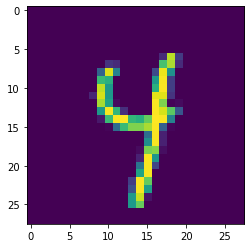

tensor(4)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[26].reshape(28,28))
plt.show()
print(y_train[26])

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train[0].shape

torch.Size([1, 28, 28])

### **Начальные параметры**

In [ ]:
n_epoch = 60
activation_function = 'ReLU' 
# activation_function = 'Tanh' 
pooling = 'MaxPool2d'
lr = 0.01
batch_size = 120

### **Класс LeNet5**

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        

        # img 28x28px
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2) #stride = 1 по умолчанию   #img 28x28px
        self.act1  = eval(f'torch.nn.{activation_function}()') 
        self.pool1 = eval(f'torch.nn.{pooling}(kernel_size=2, stride=2)') #img 14x14px
       
        # img 14x14px
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) #img 10x10px
        self.act2  = eval(f'torch.nn.{activation_function}()') 
        self.pool2 = eval(f'torch.nn.{pooling}(kernel_size=2, stride=2)') #img 5x5px


        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = eval(f'torch.nn.{activation_function}()') 
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = eval(f'torch.nn.{activation_function}()') 
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)

        x = self.fc3(x)
        
        return x

### **Класс LeNet5 с доп. слоями**

In [ ]:
# https://core.ac.uk/download/pdf/250047587.pdf

#n-p+1

class LeNet5Add(torch.nn.Module):
    def __init__(self):
        super(LeNet5Add, self).__init__()
        
  
        #img 28x28px
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=20, kernel_size=5, padding=2)
        self.act1  = eval(f'torch.nn.{activation_function}()') 
        self.pool1 = eval(f'torch.nn.{pooling}(kernel_size=2, stride=2)') #img 14x14px
       
        #img 14x14px
        self.conv2 = torch.nn.Conv2d(
            in_channels=20, out_channels=40, kernel_size=3, padding=1) #img 14x14px
        self.act2  = eval(f'torch.nn.{activation_function}()') 
        self.pool2 = eval(f'torch.nn.{pooling}(kernel_size=2, stride=2)') #img 7x7px


        #img 7x7px
        self.conv3 = torch.nn.Conv2d(
            in_channels=40, out_channels=80, kernel_size=3, padding=0) #img 5x5px
        self.act3  = eval(f'torch.nn.{activation_function}()') 
        self.pool3 = eval(f'torch.nn.{pooling}(kernel_size=2, stride=1)') #img 4x4px

        
        self.fc1   = torch.nn.Linear(4 * 4 * 80, 200) 
        self.act3  = eval(f'torch.nn.{activation_function}()') 
        
        self.fc2   = torch.nn.Linear(200, 100)
        self.act4  = eval(f'torch.nn.{activation_function}()') 

        self.fc3   = torch.nn.Linear(100, 50)
        self.act5  = eval(f'torch.nn.{activation_function}()') 

       
        self.fc4   = torch.nn.Linear(50, 10)

    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)

        x = self.fc3(x)
        x = self.act5(x)

        x = self.fc4(x)
        
        return x

### **Процесс обучения**

In [ ]:
# lenet5 = LeNet5()
lenet5 = LeNet5Add()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(lenet5.parameters(), lr=lr)
optimizer = torch.optim.SGD(lenet5.parameters(), lr=lr, momentum = 0.9,  nesterov=False)
#optimizer = torch.optim.Adam(lenet5.parameters(), lr=lr)

In [ ]:
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)


best_lenet5 = copy.deepcopy(lenet5)
best_val_acc = 0
early_stopping_patience = 20
best_epoch_i = 0

start_time = time.time()
for epoch in range(n_epoch):
    order = np.random.permutation(len(X_train))
    train_batch_loss_history = [] 
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        train_batch_loss_history.append(loss_value.tolist()) 

        optimizer.step()


    #ошибка нейросети по тестовым данным    
    test_preds = lenet5.forward(X_test)

    test_loss = loss(test_preds, y_test).data.cpu()
    test_loss_history.append(test_loss.tolist())
    
    #ошибка нейросети по трейновому датасету
    train_loss = np.mean(train_batch_loss_history)
    train_loss_history.append(train_loss)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()

    #накопление accuracy
    test_accuracy_history.append(accuracy.tolist())


    res_small = 'epoch_num = {:2d} | val_acc = {:.4f}'.format(epoch, accuracy)
    res_full =  'epoch_num = {:2d} | train_loss = {:.4f} | test_loss = {:.4f} | test_acc = {:.4f}'.format(epoch, train_loss, test_loss, accuracy)

    if (accuracy >= 0.992):
        print(colored(f'{res_full}', 'green'))
    else:
        print(colored(f'{res_full}', 'red'))


    if accuracy > best_val_acc:
        best_epoch_i = epoch
        best_val_acc = accuracy
        best_lenet5 = copy.deepcopy(lenet5)
        print('Новая лучшая модель!')
    elif epoch - best_epoch_i > early_stopping_patience:
        print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
            early_stopping_patience))
        break
    

end_time = time.time()





print(f'\n\nВремя обучения: {end_time - start_time} сек.')
print(f'test_loss_history = {test_loss_history}\n---------------------\ntrain_loss_history = {train_loss_history}')


epoch_num =  0 | train_loss = 0.7577 | test_loss = 0.1525 | test_acc = 0.9556
Новая лучшая модель!
epoch_num =  1 | train_loss = 0.1198 | test_loss = 0.0772 | test_acc = 0.9763
Новая лучшая модель!
epoch_num =  2 | train_loss = 0.0760 | test_loss = 0.0563 | test_acc = 0.9823
Новая лучшая модель!
epoch_num =  3 | train_loss = 0.0581 | test_loss = 0.0462 | test_acc = 0.9858
Новая лучшая модель!
epoch_num =  4 | train_loss = 0.0479 | test_loss = 0.0405 | test_acc = 0.9867
Новая лучшая модель!
epoch_num =  5 | train_loss = 0.0412 | test_loss = 0.0393 | test_acc = 0.9863
epoch_num =  6 | train_loss = 0.0369 | test_loss = 0.0368 | test_acc = 0.9873
Новая лучшая модель!
epoch_num =  7 | train_loss = 0.0318 | test_loss = 0.0343 | test_acc = 0.9885
Новая лучшая модель!
epoch_num =  8 | train_loss = 0.0286 | test_loss = 0.0339 | test_acc = 0.9882
epoch_num =  9 | train_loss = 0.0263 | test_loss = 0.0342 | test_acc = 0.9877
epoch_num = 10 | train_loss = 0.0231 | test_loss = 0.0314 | test_acc = 0.

### **График точности для тестовых данных**

Text(0, 0.5, '\nТочность распознавания')

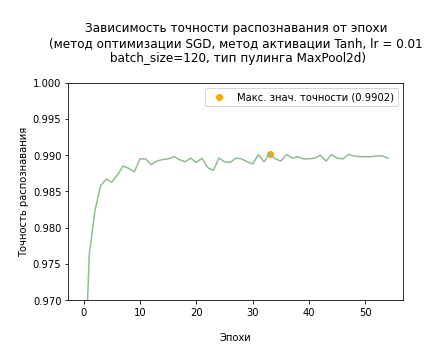

In [ ]:
max_accuracy = np.max(test_accuracy_history)
index_max_accuracy = test_accuracy_history.index(max_accuracy)

plt.plot(test_accuracy_history, color='darkseagreen')


plt.ylim(0.97, 1)

plt.title(f'\nЗависимость точности распознавания от эпохи\n(метод оптимизации SGD, метод активации {activation_function}, lr = {lr}\n batch_size={batch_size}, тип пулинга {pooling})\n')
# plt.axhline(0.992, color='r', linestyle='--', label='Мин. допустимое знач. точности (0.992)')
plt.scatter(index_max_accuracy, max_accuracy, color='orange', marker='o', label =f'Макс. знач. точности ({max_accuracy:.4f})')
plt.legend()
plt.xlabel('\nЭпохи') 
plt.ylabel('\nТочность распознавания')


### **test_loss_history & train_loss_history**

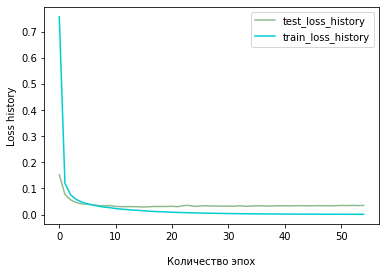

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(test_loss_history, label = 'test_loss_history', color='darkseagreen')
ax1.plot(train_loss_history, label = 'train_loss_history', color='darkturquoise')
ax1.set_xlabel('\nКоличество эпох')
ax1.set_ylabel('Loss history')
ax1.legend()

### **Зависимость точности от кол-ва слоёв**

Время на конв. слой составило 12.022497653961182 сек. на элемент: 0.08348956704139708 мсек. 
Время на полн. слой составило 9.81961703300476 сек. на элемент: 0.9819617033004762 мсек. 



Text(0, 0.5, 'Точность распознавания\n')

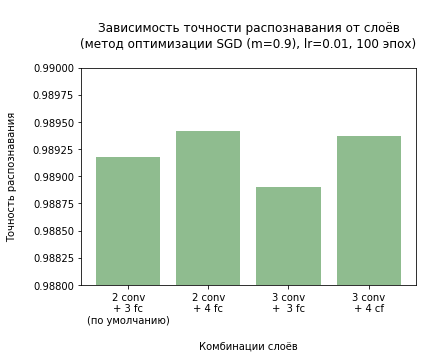

In [ ]:
# n_epoch = 100
# activation_function = 'Tanh' #tanh
# pooling = 'MaxPool2d'
# lr = 0.01
# batch_size = 100
#SGD, momentum = 0.9

# print(test_accuracy_history)
x_layers = ['2 conv\n+ 3 fc\n(по умолчанию)', '2 conv\n+ 4 fc', '3 conv\n+  3 fc', '3 conv\n+ 4 cf']
y_1 = [0.9630999565124512, 0.9788999557495117, 0.9825999736785889, 0.9864999651908875, 0.9873999953269958, 0.9864999651908875, 0.9869999885559082, 0.9879999756813049, 0.9884999990463257, 0.9888999462127686, 0.989799976348877, 0.9898999929428101, 0.9888999462127686, 0.9894999861717224, 0.9892999529838562, 0.9899999499320984, 0.9901999831199646, 0.9896000027656555, 0.9887999892234802, 0.989799976348877, 0.9896000027656555, 0.9896999597549438, 0.9886999726295471, 0.9881999492645264, 0.9896000027656555, 0.9894999861717224, 0.989799976348877, 0.9892999529838562, 0.989799976348877, 0.9896000027656555, 0.9893999695777893, 0.9900999665260315, 0.9894999861717224, 0.9899999499320984, 0.9898999929428101, 0.9892999529838562, 0.989799976348877, 0.9898999929428101, 0.9896999597549438, 0.9900999665260315, 0.9898999929428101, 0.9896999597549438, 0.9900999665260315, 0.989799976348877, 0.989799976348877, 0.9900999665260315, 0.9898999929428101, 0.989799976348877, 0.9898999929428101, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.989799976348877, 0.9902999997138977, 0.9901999831199646, 0.9898999929428101, 0.989799976348877, 0.9894999861717224, 0.989799976348877, 0.9902999997138977, 0.9896999597549438, 0.9899999499320984, 0.9900999665260315, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.9896999597549438, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.989799976348877, 0.9898999929428101, 0.989799976348877, 0.9896999597549438, 0.9898999929428101, 0.9898999929428101, 0.9899999499320984, 0.9896999597549438, 0.989799976348877, 0.989799976348877, 0.9900999665260315, 0.989799976348877, 0.9901999831199646, 0.989799976348877, 0.9896999597549438, 0.9898999929428101, 0.989799976348877, 0.989799976348877, 0.989799976348877, 0.9896999597549438, 0.9896000027656555, 0.989799976348877, 0.9894999861717224, 0.9896000027656555, 0.9898999929428101, 0.989799976348877]
y_2 = [0.9593999981880188, 0.9784999489784241, 0.982699990272522, 0.9858999848365784, 0.986299991607666, 0.9863999485969543, 0.9871999621391296, 0.9878999590873718, 0.9890999794006348, 0.9873999953269958, 0.9893999695777893, 0.9891999959945679, 0.9891999959945679, 0.9890999794006348, 0.9889999628067017, 0.9884999990463257, 0.9896999597549438, 0.9887999892234802, 0.9890999794006348, 0.9906999468803406, 0.9900999665260315, 0.9905999898910522, 0.9894999861717224, 0.9894999861717224, 0.9906999468803406, 0.9898999929428101, 0.9888999462127686, 0.9906999468803406, 0.9900999665260315, 0.9902999997138977, 0.9901999831199646, 0.9901999831199646, 0.990399956703186, 0.9905999898910522, 0.990399956703186, 0.9901999831199646, 0.9900999665260315, 0.9901999831199646, 0.9904999732971191, 0.9902999997138977, 0.9905999898910522, 0.9904999732971191, 0.9902999997138977, 0.9902999997138977, 0.9901999831199646, 0.9902999997138977, 0.9902999997138977, 0.9900999665260315, 0.9900999665260315, 0.9902999997138977, 0.9902999997138977, 0.9900999665260315, 0.9901999831199646, 0.9902999997138977, 0.9902999997138977, 0.9901999831199646, 0.9899999499320984, 0.9901999831199646, 0.9900999665260315, 0.9902999997138977, 0.9904999732971191, 0.9902999997138977, 0.990399956703186, 0.9901999831199646, 0.9902999997138977, 0.9901999831199646, 0.9904999732971191, 0.9902999997138977, 0.9902999997138977, 0.9900999665260315, 0.9901999831199646, 0.9901999831199646, 0.9900999665260315, 0.9902999997138977, 0.9899999499320984, 0.9902999997138977, 0.9901999831199646, 0.9898999929428101, 0.9900999665260315, 0.9901999831199646, 0.9901999831199646, 0.9901999831199646, 0.9902999997138977, 0.9902999997138977, 0.9901999831199646, 0.9902999997138977, 0.9900999665260315, 0.9900999665260315, 0.9902999997138977, 0.9904999732971191, 0.9902999997138977, 0.9901999831199646, 0.9900999665260315, 0.9902999997138977, 0.9902999997138977, 0.9902999997138977, 0.9902999997138977, 0.9902999997138977, 0.9901999831199646, 0.9902999997138977]
y_3 = [0.8199999928474426, 0.9700999855995178, 0.979699969291687, 0.9857999682426453, 0.9866999983787537, 0.9884999990463257, 0.9882999658584595, 0.9871999621391296, 0.9894999861717224, 0.9892999529838562, 0.989799976348877, 0.9907999634742737, 0.9898999929428101, 0.9908999800682068, 0.9910999536514282, 0.990399956703186, 0.9900999665260315, 0.9899999499320984, 0.9902999997138977, 0.9910999536514282, 0.9908999800682068, 0.9905999898910522, 0.9909999966621399, 0.9906999468803406, 0.9907999634742737, 0.9907999634742737, 0.990399956703186, 0.9909999966621399, 0.9906999468803406, 0.990399956703186, 0.9905999898910522, 0.9914999604225159, 0.989799976348877, 0.9907999634742737, 0.9909999966621399, 0.9909999966621399, 0.9911999702453613, 0.9907999634742737, 0.9910999536514282, 0.9906999468803406, 0.9908999800682068, 0.9910999536514282, 0.9907999634742737, 0.9910999536514282, 0.9914000034332275, 0.9912999868392944, 0.9910999536514282, 0.9916999936103821, 0.991599977016449, 0.9914000034332275, 0.991599977016449, 0.9912999868392944, 0.9904999732971191, 0.9917999505996704, 0.9911999702453613, 0.9914999604225159, 0.9917999505996704, 0.9911999702453613, 0.9912999868392944, 0.991599977016449, 0.9914999604225159, 0.9914999604225159, 0.9914999604225159, 0.9914000034332275, 0.9914000034332275, 0.9912999868392944, 0.991599977016449, 0.991599977016449, 0.9914000034332275, 0.991599977016449, 0.9914999604225159, 0.9917999505996704, 0.9912999868392944, 0.9912999868392944, 0.9914999604225159, 0.9914999604225159, 0.9909999966621399, 0.9914000034332275, 0.9912999868392944, 0.9914000034332275, 0.991599977016449, 0.991599977016449, 0.9916999936103821, 0.9914999604225159, 0.9912999868392944, 0.9912999868392944, 0.9914000034332275, 0.9912999868392944, 0.9912999868392944, 0.9911999702453613, 0.991599977016449, 0.991599977016449, 0.9914999604225159, 0.9914000034332275, 0.9914000034332275, 0.991599977016449, 0.9914999604225159, 0.9916999936103821, 0.9916999936103821, 0.9914000034332275]
y_4 = [0.9527999758720398, 0.9750999808311462, 0.9813999533653259, 0.9843999743461609, 0.9875999689102173, 0.9869999885559082, 0.988099992275238, 0.988599956035614, 0.9886999726295471, 0.9888999462127686, 0.9879999756813049, 0.9890999794006348, 0.9896999597549438, 0.9888999462127686, 0.9894999861717224, 0.9896999597549438, 0.9898999929428101, 0.9896999597549438, 0.989799976348877, 0.989799976348877, 0.990399956703186, 0.9887999892234802, 0.9888999462127686, 0.9898999929428101, 0.9893999695777893, 0.9884999990463257, 0.9891999959945679, 0.9894999861717224, 0.9894999861717224, 0.9896000027656555, 0.9894999861717224, 0.9896999597549438, 0.9891999959945679, 0.9902999997138977, 0.9902999997138977, 0.9899999499320984, 0.9899999499320984, 0.9896000027656555, 0.9898999929428101, 0.9898999929428101, 0.9896000027656555, 0.9898999929428101, 0.9901999831199646, 0.9899999499320984, 0.9902999997138977, 0.9902999997138977, 0.9902999997138977, 0.9905999898910522, 0.9905999898910522, 0.990399956703186, 0.9901999831199646, 0.990399956703186, 0.990399956703186, 0.9904999732971191, 0.990399956703186, 0.9904999732971191, 0.9905999898910522, 0.9905999898910522, 0.9901999831199646, 0.9905999898910522, 0.9905999898910522, 0.9904999732971191, 0.9905999898910522, 0.9905999898910522, 0.990399956703186, 0.9904999732971191, 0.990399956703186, 0.990399956703186, 0.9904999732971191, 0.990399956703186, 0.9904999732971191, 0.9904999732971191, 0.990399956703186, 0.990399956703186, 0.9905999898910522, 0.9905999898910522, 0.9905999898910522, 0.9905999898910522, 0.990399956703186, 0.9904999732971191, 0.9905999898910522, 0.9905999898910522, 0.9905999898910522, 0.9904999732971191, 0.9904999732971191, 0.9905999898910522, 0.9905999898910522, 0.9904999732971191, 0.9904999732971191, 0.9904999732971191, 0.9905999898910522, 0.9906999468803406, 0.9905999898910522, 0.9905999898910522, 0.9904999732971191, 0.9904999732971191, 0.9905999898910522, 0.9905999898910522, 0.990399956703186, 0.9905999898910522]

#время выполнения
y_time_1 = 161.4029610157013
y_time_2 = 172.03236031532288
y_time_3 = 174.2352409362793 
y_time_4 = 184.05485796928406 

print(f'Время на конв. слой составило {y_time_4 - y_time_2} сек. на элемент: {(((y_time_4 - y_time_2)/100)/1440) * 1000} мсек. ')
print(f'Время на полн. слой составило {y_time_4 - y_time_3} сек. на элемент: {(((y_time_4 - y_time_3)/100)/100) * 1000} мсек. \n')

#print(sorted([np.mean(y_1), np.mean(y_2),np.mean(y_3),np.mean(y_4)]))

fig, ax1 = plt.subplots()
ax1.set_ylim(0.988, 0.99)

ax1.title.set_text('\nЗависимость точности распознавания от слоёв\n(метод оптимизации SGD (m=0.9), lr=0.01, 100 эпох)\n')
ax1.bar(x_layers, [np.mean(y_1), np.mean(y_2),np.mean(y_3),np.mean(y_4)], color='darkseagreen')
ax1.set_xlabel('\nКомбинации слоёв')
ax1.set_ylabel('Точность распознавания\n')

### **CPU vs GPU**

In [ ]:
# n_epoch = 100
# activation_function = 'Tanh' #tanh
# pooling = 'MaxPool2d'
# lr = 0.01
# batch_size = 100
#SGD, momentum = 0.9
#2 свёрточных + 3 полносвязных (по умолчанию)

GPU_computing_time  = 161.4029610157013
CPU_computing_time  = 1115.3061335086823

print('SGD (momentum=0.9), lr=0.01, 100 эпох, batch_size=100')
print(f'GPU_computing_time = {GPU_computing_time} сек. или {GPU_computing_time/60} мин.')
print(f'CPU_computing_time = {CPU_computing_time} сек. или {CPU_computing_time/60} мин.')
print(f'Вычисления на GPU быстрее, чем на CPU в {CPU_computing_time/GPU_computing_time:.2f} раз')

SGD (momentum=0.9), lr=0.01, 100 эпох, batch_size=100
GPU_computing_time = 161.4029610157013 сек. или 2.6900493502616882 мин.
CPU_computing_time = 1115.3061335086823 сек. или 18.588435558478036 мин.
Вычисления на GPU быстрее, чем на CPU в 6.91 раз


### **Зависимость точности от функции активации**

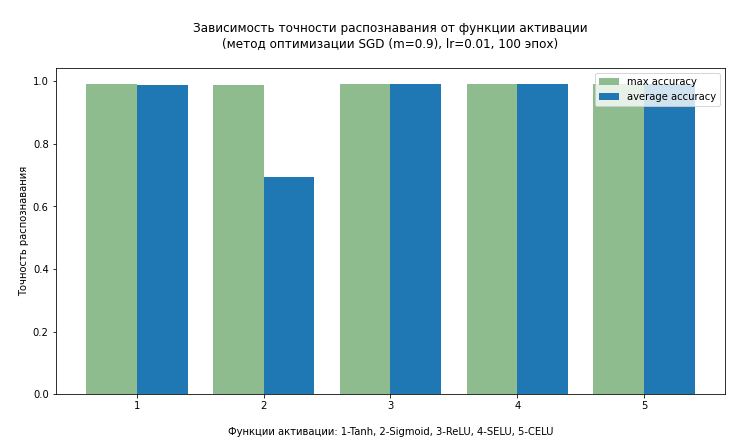

In [ ]:
# n_epoch = 100
# pooling = 'MaxPool2d'
# lr = 0.01
# batch_size = 100
#SGD, momentum = 0.9
#архитектура по умолчанию

x_activation_functions = ['Tanh', 'Sigmoid', 'ReLU', 'SELU', 'CELU']
y_Tanh =    [0.9630999565124512, 0.9788999557495117, 0.9825999736785889, 0.9864999651908875, 0.9873999953269958, 0.9864999651908875, 0.9869999885559082, 0.9879999756813049, 0.9884999990463257, 0.9888999462127686, 0.989799976348877, 0.9898999929428101, 0.9888999462127686, 0.9894999861717224, 0.9892999529838562, 0.9899999499320984, 0.9901999831199646, 0.9896000027656555, 0.9887999892234802, 0.989799976348877, 0.9896000027656555, 0.9896999597549438, 0.9886999726295471, 0.9881999492645264, 0.9896000027656555, 0.9894999861717224, 0.989799976348877, 0.9892999529838562, 0.989799976348877, 0.9896000027656555, 0.9893999695777893, 0.9900999665260315, 0.9894999861717224, 0.9899999499320984, 0.9898999929428101, 0.9892999529838562, 0.989799976348877, 0.9898999929428101, 0.9896999597549438, 0.9900999665260315, 0.9898999929428101, 0.9896999597549438, 0.9900999665260315, 0.989799976348877, 0.989799976348877, 0.9900999665260315, 0.9898999929428101, 0.989799976348877, 0.9898999929428101, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.989799976348877, 0.9902999997138977, 0.9901999831199646, 0.9898999929428101, 0.989799976348877, 0.9894999861717224, 0.989799976348877, 0.9902999997138977, 0.9896999597549438, 0.9899999499320984, 0.9900999665260315, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.9896999597549438, 0.9898999929428101, 0.9900999665260315, 0.9899999499320984, 0.989799976348877, 0.9898999929428101, 0.989799976348877, 0.9896999597549438, 0.9898999929428101, 0.9898999929428101, 0.9899999499320984, 0.9896999597549438, 0.989799976348877, 0.989799976348877, 0.9900999665260315, 0.989799976348877, 0.9901999831199646, 0.989799976348877, 0.9896999597549438, 0.9898999929428101, 0.989799976348877, 0.989799976348877, 0.989799976348877, 0.9896999597549438, 0.9896000027656555, 0.989799976348877, 0.9894999861717224, 0.9896000027656555, 0.9898999929428101, 0.989799976348877]
y_Sigmoid = [0.11349999904632568, 0.10319999605417252, 0.11349999904632568, 0.10279999673366547, 0.10089999437332153, 0.11349999904632568, 0.10279999673366547, 0.11349999904632568, 0.09799999743700027, 0.09799999743700027, 0.11349999904632568, 0.11349999904632568, 0.0982000008225441, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.10279999673366547, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.12139999866485596, 0.2500999867916107, 0.3249000012874603, 0.5144999623298645, 0.7422999739646912, 0.8166999816894531, 0.8624999523162842, 0.9018999934196472, 0.925599992275238, 0.9418999552726746, 0.9506999850273132, 0.9547999501228333, 0.9569999575614929, 0.9625999927520752, 0.9648000001907349, 0.9673999547958374, 0.9687999486923218, 0.9703999757766724, 0.9717999696731567, 0.9734999537467957, 0.973800003528595, 0.9756999611854553, 0.975600004196167, 0.9765999913215637, 0.9777999520301819, 0.9782999753952026, 0.9789999723434448, 0.98089998960495, 0.9799000024795532, 0.98089998960495, 0.979699969291687, 0.9824000000953674, 0.9817999601364136, 0.9835999608039856, 0.9817000031471252, 0.9793999791145325, 0.9815999865531921, 0.9838999509811401, 0.9829999804496765, 0.9829999804496765, 0.9848999977111816, 0.9843999743461609, 0.9833999872207642, 0.9824999570846558, 0.9842999577522278, 0.9842000007629395, 0.9850999712944031, 0.9860000014305115, 0.9855999946594238, 0.9853999614715576, 0.9861999750137329, 0.9853999614715576, 0.9833999872207642, 0.9866999983787537, 0.9830999970436096, 0.9853999614715576, 0.9861999750137329, 0.9863999485969543, 0.9860999584197998, 0.986299991607666, 0.9868999719619751, 0.9869999885559082, 0.9860999584197998, 0.9871999621391296, 0.9868999719619751, 0.9866999983787537, 0.9865999817848206, 0.9878000020980835, 0.986799955368042, 0.986299991607666, 0.9875999689102173]
y_ReLU = [0.9614999890327454, 0.9774999618530273, 0.9842000007629395, 0.986799955368042, 0.9820999503135681, 0.9887999892234802, 0.9873999953269958, 0.9904999732971191, 0.9896999597549438, 0.9902999997138977, 0.9900999665260315, 0.991599977016449, 0.9907999634742737, 0.9908999800682068, 0.9890999794006348, 0.9894999861717224, 0.9914000034332275, 0.991599977016449, 0.9914000034332275, 0.9901999831199646, 0.9907999634742737, 0.9916999936103821, 0.9908999800682068, 0.9892999529838562, 0.9908999800682068, 0.9914999604225159, 0.9907999634742737, 0.9919999837875366, 0.991599977016449, 0.9904999732971191, 0.9918999671936035, 0.9910999536514282, 0.989799976348877, 0.9909999966621399, 0.9917999505996704, 0.989799976348877, 0.9908999800682068, 0.9904999732971191, 0.9921999573707581, 0.9907999634742737, 0.9916999936103821, 0.9918999671936035, 0.9921999573707581, 0.9918999671936035, 0.9921999573707581, 0.9917999505996704, 0.9918999671936035, 0.9914999604225159, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9917999505996704, 0.991599977016449, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9914999604225159, 0.9917999505996704, 0.9916999936103821, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.991599977016449, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704]
y_SELU = [0.9768999814987183, 0.9829999804496765, 0.9870999455451965, 0.988599956035614, 0.9878999590873718, 0.9879999756813049, 0.9899999499320984, 0.9891999959945679, 0.9900999665260315, 0.9910999536514282, 0.9896999597549438, 0.9909999966621399, 0.9904999732971191, 0.9899999499320984, 0.9909999966621399, 0.9912999868392944, 0.9914000034332275, 0.9899999499320984, 0.9910999536514282, 0.9907999634742737, 0.9905999898910522, 0.991599977016449, 0.9912999868392944, 0.9909999966621399, 0.9907999634742737, 0.9918999671936035, 0.9918999671936035, 0.991599977016449, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9914000034332275, 0.9914000034332275, 0.9914000034332275, 0.9916999936103821, 0.9914999604225159, 0.991599977016449, 0.9917999505996704, 0.9916999936103821, 0.9914000034332275, 0.9914999604225159, 0.9916999936103821, 0.9911999702453613, 0.9914999604225159, 0.9914999604225159, 0.9916999936103821, 0.9914999604225159, 0.9914999604225159, 0.991599977016449, 0.991599977016449, 0.991599977016449, 0.9914999604225159, 0.991599977016449, 0.9914999604225159, 0.9914999604225159, 0.9914999604225159, 0.9914999604225159, 0.9912999868392944, 0.9914999604225159, 0.9914999604225159, 0.9912999868392944, 0.9911999702453613, 0.9914000034332275, 0.9912999868392944, 0.9914999604225159, 0.9914000034332275, 0.9912999868392944, 0.9911999702453613, 0.9914000034332275, 0.9912999868392944, 0.9912999868392944, 0.9910999536514282, 0.9912999868392944, 0.9912999868392944, 0.9912999868392944, 0.9914000034332275, 0.9912999868392944, 0.9914000034332275, 0.9914000034332275, 0.9911999702453613, 0.9912999868392944, 0.9912999868392944, 0.9911999702453613, 0.9912999868392944, 0.9914999604225159, 0.9911999702453613, 0.9914000034332275, 0.9912999868392944, 0.9912999868392944, 0.9914000034332275, 0.9911999702453613, 0.9911999702453613, 0.9912999868392944, 0.9912999868392944, 0.9911999702453613, 0.9912999868392944, 0.9911999702453613, 0.9911999702453613, 0.9912999868392944, 0.9911999702453613]
y_CELU = [0.964199960231781, 0.9813999533653259, 0.9870999455451965, 0.9891999959945679, 0.9875999689102173, 0.9884999990463257, 0.9882999658584595, 0.9902999997138977, 0.9904999732971191, 0.990399956703186, 0.9904999732971191, 0.9911999702453613, 0.9905999898910522, 0.9892999529838562, 0.991599977016449, 0.9907999634742737, 0.9906999468803406, 0.9909999966621399, 0.990399956703186, 0.9889999628067017, 0.9910999536514282, 0.9910999536514282, 0.9908999800682068, 0.9900999665260315, 0.9918999671936035, 0.9914000034332275, 0.9916999936103821, 0.9911999702453613, 0.9916999936103821, 0.9905999898910522, 0.9892999529838562, 0.9908999800682068, 0.988599956035614, 0.9891999959945679, 0.9905999898910522, 0.991599977016449, 0.991599977016449, 0.9916999936103821, 0.9901999831199646, 0.9916999936103821, 0.9916999936103821, 0.9919999837875366, 0.9914999604225159, 0.9917999505996704, 0.9916999936103821, 0.9919999837875366, 0.9919999837875366, 0.9916999936103821, 0.9914000034332275, 0.9917999505996704, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9916999936103821, 0.991599977016449, 0.9916999936103821, 0.9916999936103821, 0.991599977016449, 0.9917999505996704, 0.991599977016449, 0.9914000034332275, 0.9917999505996704, 0.9918999671936035, 0.991599977016449, 0.9918999671936035, 0.991599977016449, 0.991599977016449, 0.9914000034332275, 0.9916999936103821, 0.9914999604225159, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.9916999936103821, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9914000034332275, 0.9917999505996704, 0.991599977016449, 0.9916999936103821, 0.9916999936103821, 0.991599977016449, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.991599977016449, 0.9914999604225159, 0.991599977016449, 0.991599977016449, 0.9914999604225159, 0.9914999604225159, 0.9914999604225159, 0.9917999505996704, 0.9916999936103821, 0.991599977016449, 0.9914999604225159, 0.9912999868392944]
# print(test_accuracy_history)


x1 = np.arange(1, 6) - 0.2
x2 = np.arange(1, 6) + 0.2
y1 = [np.max(y_Tanh), np.max(y_Sigmoid), np.max(y_ReLU), np.max(y_SELU), np.max(y_CELU) ]
y2 = [np.mean(y_Tanh), np.mean(y_Sigmoid), np.mean(y_ReLU), np.mean(y_SELU), np.mean(y_CELU)]

fig, ax = plt.subplots()

ax.bar(x1, y1, width = 0.4, label = 'max accuracy', color='darkseagreen')
ax.bar(x2, y2, width = 0.4, label = 'average accuracy')
ax.legend()
ax.title.set_text('\nЗависимость точности распознавания от функции активации\n(метод оптимизации SGD (m=0.9), lr=0.01, 100 эпох)\n')
ax.set_xlabel('\nФункции активации: 1-Tanh, 2-Sigmoid, 3-ReLU, 4-SELU, 5-CELU')
ax.set_ylabel('\nТочность распознавания')
fig.set_figwidth(12)  
fig.set_figheight(6)    





### **Зависимость точности от шага градиентного спуска**

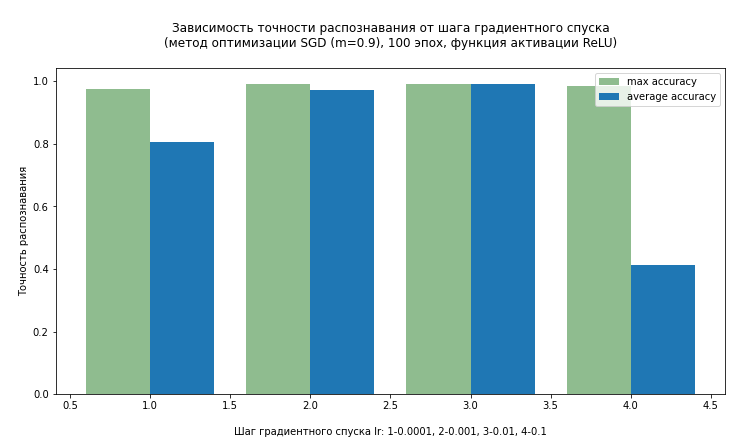

In [ ]:
# n_epoch = 100
# pooling = 'MaxPool2d'
# lr = 0.01
# batch_size = 100
#SGD, momentum = 0.9
#архитектура по умолчанию
#ReLU

x_lrs = ['0.0001', '0.001', '0.01', '0.1']

y_ReLU_0_0001 = [0.10089999437332153, 0.10089999437332153, 0.10089999437332153, 0.10179999470710754, 0.10740000009536743, 0.13729999959468842, 0.17549999058246613, 0.18719999492168427, 0.21389999985694885, 0.2467999905347824, 0.26429998874664307, 0.2689000070095062, 0.26420000195503235, 0.25939998030662537, 0.25040000677108765, 0.27809998393058777, 0.34759998321533203, 0.4697999954223633, 0.5708999633789062, 0.7008000016212463, 0.7752000093460083, 0.8077999949455261, 0.8290999531745911, 0.8489999771118164, 0.8578000068664551, 0.8693000078201294, 0.8777999877929688, 0.8833000063896179, 0.8872999548912048, 0.8953999876976013, 0.8985999822616577, 0.9032999873161316, 0.9071999788284302, 0.9091999530792236, 0.9140999913215637, 0.9157999753952026, 0.9197999835014343, 0.9241999983787537, 0.925599992275238, 0.9277999997138977, 0.930899977684021, 0.9325999617576599, 0.9350000023841858, 0.9391999840736389, 0.9407999515533447, 0.9414999485015869, 0.9429999589920044, 0.9455999732017517, 0.9474999904632568, 0.9483000040054321, 0.9490999579429626, 0.9510999917984009, 0.9512999653816223, 0.9510999917984009, 0.9536999464035034, 0.9536999464035034, 0.9549999833106995, 0.9560999870300293, 0.957099974155426, 0.958299994468689, 0.9585999846458435, 0.9603999853134155, 0.9607999920845032, 0.9612999558448792, 0.9612999558448792, 0.9629999995231628, 0.9625999927520752, 0.9645999670028687, 0.9655999541282654, 0.9661999940872192, 0.9656999707221985, 0.9652999639511108, 0.9675999879837036, 0.967199981212616, 0.9668999910354614, 0.9690999984741211, 0.9691999554634094, 0.9691999554634094, 0.9699999690055847, 0.9708999991416931, 0.9704999923706055, 0.9708999991416931, 0.9722999930381775, 0.9723999500274658, 0.9710999727249146, 0.9723999500274658, 0.972599983215332, 0.9721999764442444, 0.9708999991416931, 0.973800003528595, 0.9745999574661255, 0.9752999544143677, 0.9736999869346619, 0.9740999937057495, 0.9738999605178833, 0.9747999906539917, 0.9757999777793884, 0.9753999710083008, 0.9729999899864197, 0.9753999710083008]
y_ReLU_0_001 = [0.23099999129772186, 0.604200005531311, 0.877299964427948, 0.920199990272522, 0.942799985408783, 0.9520999789237976, 0.960599958896637, 0.9687999486923218, 0.9678999781608582, 0.9721999764442444, 0.9749999642372131, 0.9777999520301819, 0.9772999882698059, 0.9801999926567078, 0.9799000024795532, 0.98089998960495, 0.9799999594688416, 0.9813999533653259, 0.9827999472618103, 0.9827999472618103, 0.984499990940094, 0.9842999577522278, 0.9835000038146973, 0.9845999479293823, 0.9846999645233154, 0.9838999509811401, 0.9836999773979187, 0.9871999621391296, 0.9868999719619751, 0.9845999479293823, 0.98499995470047, 0.9868999719619751, 0.9864999651908875, 0.9864999651908875, 0.9878999590873718, 0.9889999628067017, 0.9894999861717224, 0.9872999787330627, 0.9896999597549438, 0.9878000020980835, 0.9878999590873718, 0.9872999787330627, 0.9879999756813049, 0.9899999499320984, 0.9893999695777893, 0.9890999794006348, 0.9888999462127686, 0.9887999892234802, 0.9888999462127686, 0.9893999695777893, 0.9896000027656555, 0.9881999492645264, 0.9891999959945679, 0.9896999597549438, 0.9898999929428101, 0.9894999861717224, 0.988099992275238, 0.9878999590873718, 0.9887999892234802, 0.9896999597549438, 0.9881999492645264, 0.9893999695777893, 0.990399956703186, 0.9898999929428101, 0.9887999892234802, 0.9899999499320984, 0.9896999597549438, 0.9893999695777893, 0.9896000027656555, 0.9893999695777893, 0.9891999959945679, 0.9894999861717224, 0.9887999892234802, 0.9882999658584595, 0.9898999929428101, 0.9896000027656555, 0.9888999462127686, 0.9899999499320984, 0.9899999499320984, 0.9899999499320984, 0.9891999959945679, 0.9899999499320984, 0.9886999726295471, 0.9893999695777893, 0.988099992275238, 0.9896000027656555, 0.9893999695777893, 0.9894999861717224, 0.9900999665260315, 0.988599956035614, 0.9893999695777893, 0.9900999665260315, 0.9905999898910522, 0.9905999898910522, 0.9884999990463257, 0.9899999499320984, 0.9892999529838562, 0.9896000027656555, 0.9900999665260315, 0.9889999628067017]
y_ReLU_0_01 = [0.9614999890327454, 0.9774999618530273, 0.9842000007629395, 0.986799955368042, 0.9820999503135681, 0.9887999892234802, 0.9873999953269958, 0.9904999732971191, 0.9896999597549438, 0.9902999997138977, 0.9900999665260315, 0.991599977016449, 0.9907999634742737, 0.9908999800682068, 0.9890999794006348, 0.9894999861717224, 0.9914000034332275, 0.991599977016449, 0.9914000034332275, 0.9901999831199646, 0.9907999634742737, 0.9916999936103821, 0.9908999800682068, 0.9892999529838562, 0.9908999800682068, 0.9914999604225159, 0.9907999634742737, 0.9919999837875366, 0.991599977016449, 0.9904999732971191, 0.9918999671936035, 0.9910999536514282, 0.989799976348877, 0.9909999966621399, 0.9917999505996704, 0.989799976348877, 0.9908999800682068, 0.9904999732971191, 0.9921999573707581, 0.9907999634742737, 0.9916999936103821, 0.9918999671936035, 0.9921999573707581, 0.9918999671936035, 0.9921999573707581, 0.9917999505996704, 0.9918999671936035, 0.9914999604225159, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9917999505996704, 0.991599977016449, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9914999604225159, 0.9917999505996704, 0.9916999936103821, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.991599977016449, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704]
y_ReLU_0_1 = [0.9606999754905701, 0.9660999774932861, 0.9733999967575073, 0.9787999987602234, 0.9721999764442444, 0.9799999594688416, 0.9763000011444092, 0.9763000011444092, 0.9782999753952026, 0.9819999933242798, 0.9791999459266663, 0.9820999503135681, 0.9820999503135681, 0.9771999716758728, 0.9795999526977539, 0.9787999987602234, 0.9686999917030334, 0.9835999608039856, 0.9792999625205994, 0.9829999804496765, 0.9776999950408936, 0.9777999520301819, 0.9825999736785889, 0.9818999767303467, 0.9807999730110168, 0.9815999865531921, 0.9749999642372131, 0.9828999638557434, 0.9836999773979187, 0.974399983882904, 0.9827999472618103, 0.9824000000953674, 0.9792999625205994, 0.97489994764328, 0.9735999703407288, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.10279999673366547, 0.11349999904632568, 0.10319999605417252, 0.11349999904632568, 0.10099999606609344, 0.11349999904632568, 0.0957999974489212, 0.0973999947309494, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.10319999605417252, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.10089999437332153, 0.11349999904632568, 0.11349999904632568, 0.0957999974489212, 0.11349999904632568, 0.11349999904632568, 0.09799999743700027, 0.10099999606609344, 0.10099999606609344, 0.11349999904632568, 0.10279999673366547, 0.10319999605417252, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.09799999743700027, 0.0957999974489212, 0.10099999606609344, 0.09799999743700027, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.10279999673366547, 0.0973999947309494, 0.11349999904632568, 0.11349999904632568, 0.11349999904632568, 0.09799999743700027, 0.11349999904632568, 0.11349999904632568, 0.10279999673366547, 0.11349999904632568, 0.0982000008225441, 0.09799999743700027, 0.0982000008225441, 0.10319999605417252, 0.0973999947309494, 0.11349999904632568, 0.11349999904632568]

# print(test_accuracy_history)


x1 = np.arange(1, 5) - 0.2
x2 = np.arange(1, 5) + 0.2
y1 = [np.max(y_ReLU_0_0001), np.max(y_ReLU_0_001), np.max(y_ReLU_0_01), np.max(y_ReLU_0_1)]
y2 = [np.mean(y_ReLU_0_0001), np.mean(y_ReLU_0_001), np.mean(y_ReLU_0_01), np.mean(y_ReLU_0_1)]

fig, ax = plt.subplots()

ax.bar(x1, y1, width = 0.4, label = 'max accuracy', color='darkseagreen')
ax.bar(x2, y2, width = 0.4, label = 'average accuracy')
ax.legend()
ax.title.set_text('\nЗависимость точности распознавания от шага градиентного спуска\n(метод оптимизации SGD (m=0.9), 100 эпох, функция активации ReLU)\n')
ax.set_xlabel('\nШаг градиентного спуска lr: 1-0.0001, 2-0.001, 3-0.01, 4-0.1')
ax.set_ylabel('\nТочность распознавания')
fig.set_figwidth(12)   
fig.set_figheight(6)  





### **Зависимость точности от типа пулинга**

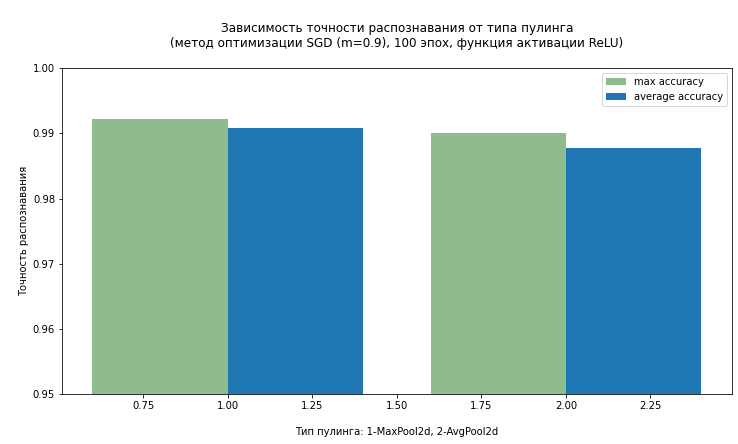

In [ ]:
# n_epoch = 100
# lr = 0.01
# batch_size = 100
#SGD, momentum = 0.9
#архитектура по умолчанию
#ReLU


y_ReLU_max_pooling = [0.9614999890327454, 0.9774999618530273, 0.9842000007629395, 0.986799955368042, 0.9820999503135681, 0.9887999892234802, 0.9873999953269958, 0.9904999732971191, 0.9896999597549438, 0.9902999997138977, 0.9900999665260315, 0.991599977016449, 0.9907999634742737, 0.9908999800682068, 0.9890999794006348, 0.9894999861717224, 0.9914000034332275, 0.991599977016449, 0.9914000034332275, 0.9901999831199646, 0.9907999634742737, 0.9916999936103821, 0.9908999800682068, 0.9892999529838562, 0.9908999800682068, 0.9914999604225159, 0.9907999634742737, 0.9919999837875366, 0.991599977016449, 0.9904999732971191, 0.9918999671936035, 0.9910999536514282, 0.989799976348877, 0.9909999966621399, 0.9917999505996704, 0.989799976348877, 0.9908999800682068, 0.9904999732971191, 0.9921999573707581, 0.9907999634742737, 0.9916999936103821, 0.9918999671936035, 0.9921999573707581, 0.9918999671936035, 0.9921999573707581, 0.9917999505996704, 0.9918999671936035, 0.9914999604225159, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9917999505996704, 0.991599977016449, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9914999604225159, 0.9917999505996704, 0.9916999936103821, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.991599977016449, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9916999936103821, 0.9918999671936035, 0.9918999671936035, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9918999671936035, 0.9917999505996704, 0.9916999936103821, 0.9916999936103821, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9918999671936035, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704, 0.9917999505996704]
y_ReLU_avg_pooling = [0.9371999502182007, 0.9651999473571777, 0.9724999666213989, 0.9822999835014343, 0.979699969291687, 0.9830999970436096, 0.9846999645233154, 0.9847999811172485, 0.9839999675750732, 0.9856999516487122, 0.9879999756813049, 0.9878000020980835, 0.9869999885559082, 0.9878000020980835, 0.9878000020980835, 0.9875999689102173, 0.9882999658584595, 0.9884999990463257, 0.9872999787330627, 0.9864999651908875, 0.9879999756813049, 0.9858999848365784, 0.9870999455451965, 0.9878999590873718, 0.9888999462127686, 0.9876999855041504, 0.9881999492645264, 0.9883999824523926, 0.9887999892234802, 0.9879999756813049, 0.9870999455451965, 0.9878000020980835, 0.9878000020980835, 0.9896000027656555, 0.988599956035614, 0.9879999756813049, 0.988599956035614, 0.9887999892234802, 0.9875999689102173, 0.9870999455451965, 0.9881999492645264, 0.988599956035614, 0.988599956035614, 0.9887999892234802, 0.9891999959945679, 0.9886999726295471, 0.9892999529838562, 0.9890999794006348, 0.9886999726295471, 0.9886999726295471, 0.9893999695777893, 0.9892999529838562, 0.9894999861717224, 0.9896000027656555, 0.9894999861717224, 0.9894999861717224, 0.9894999861717224, 0.9893999695777893, 0.9892999529838562, 0.9896999597549438, 0.9893999695777893, 0.9893999695777893, 0.9896000027656555, 0.989799976348877, 0.989799976348877, 0.9896999597549438, 0.9894999861717224, 0.9896999597549438, 0.9896999597549438, 0.9892999529838562, 0.9896999597549438, 0.9896999597549438, 0.9896000027656555, 0.9896999597549438, 0.9893999695777893, 0.9896999597549438, 0.9896000027656555, 0.9896000027656555, 0.9894999861717224, 0.9893999695777893, 0.9898999929428101, 0.9896000027656555, 0.9896999597549438, 0.9896999597549438, 0.9896999597549438, 0.989799976348877, 0.9898999929428101, 0.9896999597549438, 0.9898999929428101, 0.9899999499320984, 0.989799976348877, 0.9898999929428101, 0.9900999665260315, 0.9898999929428101, 0.989799976348877, 0.9898999929428101, 0.9898999929428101, 0.9898999929428101, 0.989799976348877, 0.9896999597549438]

#print(test_accuracy_history)


x1 = np.arange(1, 3) - 0.2
x2 = np.arange(1, 3) + 0.2
y1 = [np.max(y_ReLU_max_pooling), np.max(y_ReLU_avg_pooling)]
y2 = [np.mean(y_ReLU_max_pooling), np.mean(y_ReLU_avg_pooling)]

fig, ax = plt.subplots()

ax.bar(x1, y1, width = 0.4, label = 'max accuracy', color='darkseagreen')
ax.bar(x2, y2, width = 0.4, label = 'average accuracy')


ax.legend()
ax.title.set_text('\nЗависимость точности распознавания от типа пулинга\n(метод оптимизации SGD (m=0.9), 100 эпох, функция активации ReLU)\n')
ax.set_xlabel('\nТип пулинга: 1-MaxPool2d, 2-AvgPool2d')
ax.set_ylabel('\nТочность распознавания')
ax.set_ylim(0.95, 1)
fig.set_figwidth(12)   
fig.set_figheight(6)  



### **Проверка верности распознавания**

In [ ]:
X_test.shape
print(X_test.shape)

lenet5.to('cpu')
X_test = X_test.to('cpu')
y_test = y_test.to('cpu')

torch.Size([10000, 1, 28, 28])


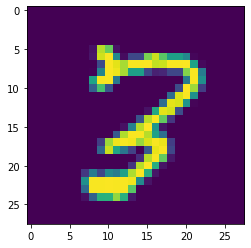

---------------------------------------
Прогноз модели: 3, правильная метка: 3 
---------------------------------------
id = 578


In [ ]:
id = 578

X_to_predict = X_test[id].reshape(1,1,28,28)
print
###########
predicted_number = lenet5.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("---------------------------------------\nПрогноз модели: {}, правильная метка: {} \n---------------------------------------".format(
    np.argmax(predicted_number), y_test[id]) 
)
print(f'id = {id}')

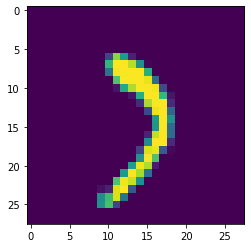

---------------------------------------
Прогноз модели: 7, правильная метка: 7 
---------------------------------------
id = 3451


In [ ]:
id = 3451
X_to_predict = X_test[id].reshape(1,1,28,28)

###########
predicted_number = lenet5.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("---------------------------------------\nПрогноз модели: {}, правильная метка: {} \n---------------------------------------".format(
    np.argmax(predicted_number), y_test[id]) 
)
print(f'id = {id}')

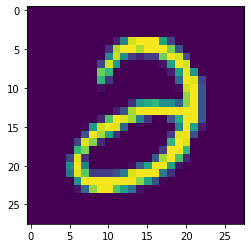

---------------------------------------
Прогноз модели: 3, правильная метка: 2 
---------------------------------------
id = 3330


In [ ]:
id = 3330
X_to_predict = X_test[id].reshape(1,1,28,28)

###########
predicted_number = lenet5.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("---------------------------------------\nПрогноз модели: {}, правильная метка: {} \n---------------------------------------".format(
    np.argmax(predicted_number), y_test[id]) 
)
print(f'id = {id}')


In [ ]:
# в данной переменной сохранены id всех объектов, которые модель неправильного предсказала
test_preds = lenet5.forward(X_test)
non_correct_ids = [id for (id,res) in enumerate(test_preds.argmax(dim=1) != y_test) if res]

In [ ]:
# Кол-во неверно пресказанных объектов
print(f'Кол-во неверно пресказанных объектов: {len(non_correct_ids)}')

Кол-во неверно пресказанных объектов: 104


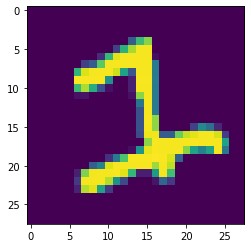

---------------------------------------
Прогноз модели: 2, Правильная метка: 1 
---------------------------------------
id = 3073


In [ ]:
# random.choice выбирает случайный id из скиска non_correct_ids по которому выбирается объект для прогноза из тестовой выборки
id = random.choice(non_correct_ids)
X_to_predict = X_test[id].reshape(1,*X_test[id].shape)
###########
predicted_number = lenet5.forward(X_to_predict).detach().numpy()
plt.imshow(X_to_predict.reshape(28,28))
plt.show()
print("---------------------------------------\nПрогноз модели: {}, Правильная метка: {} \n---------------------------------------".format(
    np.argmax(predicted_number), y_test[id]) 
)
print(f'id = {id}')


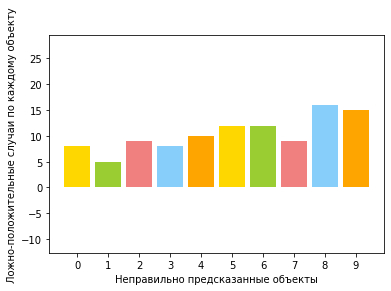

In [ ]:
import matplotlib.pyplot as plt

distance = 6
classes = 10
x = list(range(0,classes*distance,distance))

perc = np.zeros(classes).astype(int)
for id in non_correct_ids:
  perc[y_test[id]] += 1
  
width=5
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','gold','yellowgreen', 'lightcoral', 'lightskyblue','orange']
labels = list(range(0,classes))
plt.xticks(x,labels)
plt.bar(x,perc,width,align='center', color=colors)
plt.ylabel('Ложно-положительные случаи по каждому объекту')
plt.xlabel('Неправильно предсказанные объекты')
plt.axis('equal')
plt.show()